In [ ]:
import glob

import imageio.v3 as iio
import ipympl
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

%matplotlib widget


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

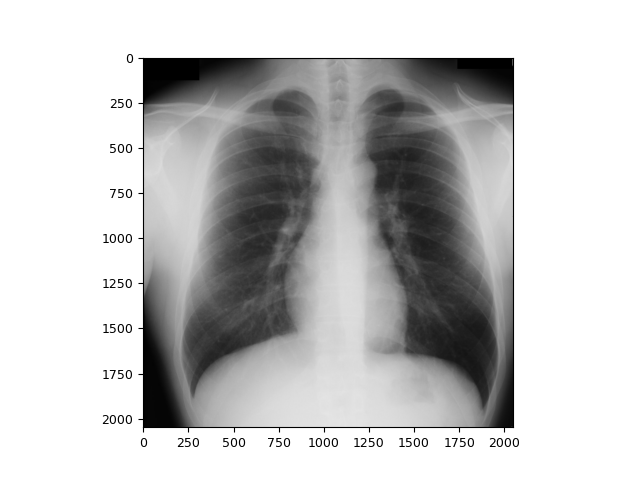

In [ ]:
maize_roots = iio.imread(uri="/content/Jpg_png.png")

fig, ax = plt.subplots()
ax.imshow(maize_roots)

(0.0, 1.0)

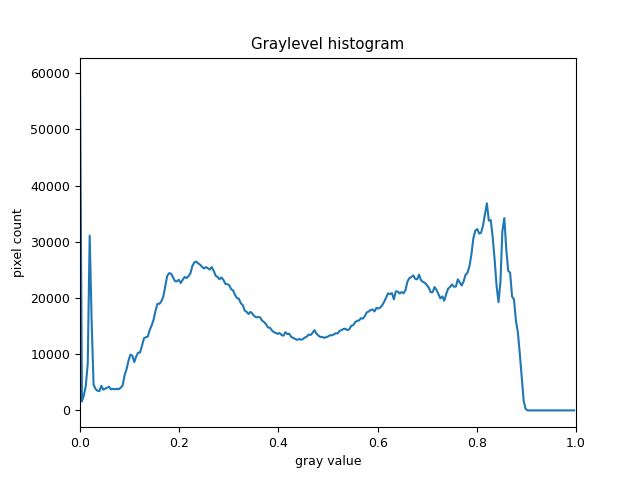

In [ ]:
# convert the image to grayscale
gray_image = ski.color.rgb2gray(maize_roots)

# blur the image to denoise
blurred_image = ski.filters.gaussian(gray_image, sigma=1.0)

# show the histogram of the blurred image
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)
ax.set_title("Graylevel histogram")
ax.set_xlabel("gray value")
ax.set_ylabel("pixel count")
ax.set_xlim(0, 1.0)

In [ ]:
# perform automatic thresholding
t = ski.filters.threshold_otsu(blurred_image)
print("Found automatic threshold t = {}.".format(t))

Found automatic threshold t = 0.48091848215576516.


<ipython-input-70-e9229b8b02e9>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


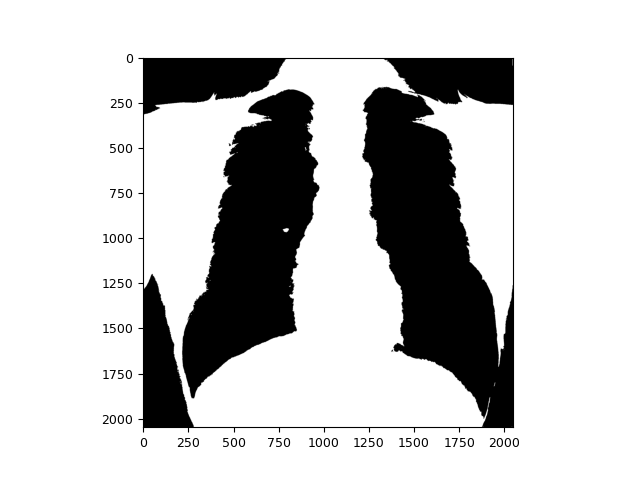

In [ ]:
# create a binary mask with the threshold found by Otsu's method
binary_mask = blurred_image > t

fig, ax = plt.subplots()
ax.imshow(binary_mask, cmap="gray")

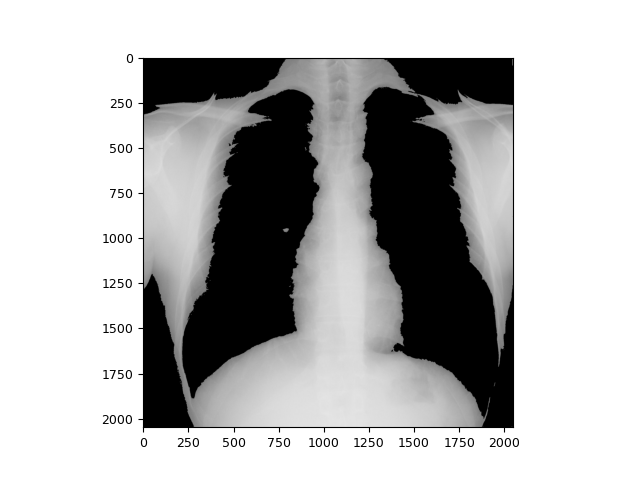

In [ ]:
# apply the binary mask to select the foreground
selection = maize_roots.copy()
selection[~binary_mask] = 0

fig, ax = plt.subplots()
ax.imshow(selection)

In [ ]:
def measure_root_mass(filename, sigma=1.0):

    # read the original image, converting to grayscale on the fly
    image = iio.imread(uri=filename, mode="L")

    # blur before thresholding
    blurred_image = ski.filters.gaussian(image, sigma=sigma)

    # perform automatic thresholding to produce a binary image
    t = ski.filters.threshold_otsu(blurred_image)
    binary_mask = blurred_image > t

    # determine root mass ratio
    root_pixels = np.count_nonzero(binary_mask)
    w = binary_mask.shape[1]
    h = binary_mask.shape[0]
    density = root_pixels / (w * h)

    return density

In [ ]:
measure_root_mass(filename="/content/shapes-01.jpg", sigma=1.5)

0.8299892439397003

<ipython-input-74-88e1501498b2>:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')


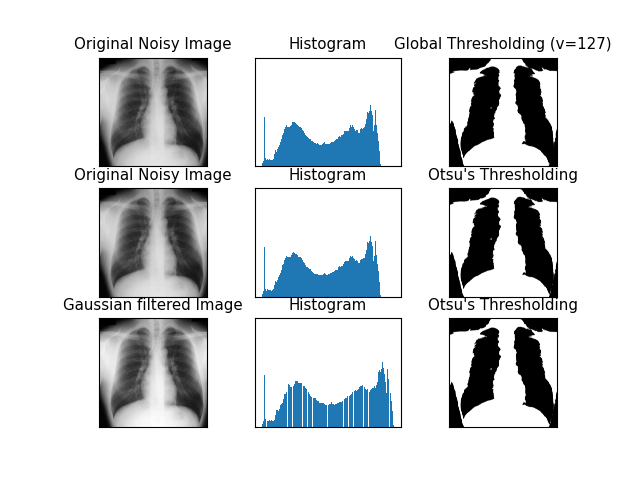

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/content/Jpg_png.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
img = cv.imread('/content/Jpg_png.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
blur = cv.GaussianBlur(img,(5,5),0)

# find normalized_histogram, and its cumulative distribution function
hist = cv.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.sum()
Q = hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    if q1 < 1.e-6 or q2 < 1.e-6:
        continue
    b1,b2 = np.hsplit(bins,[i]) # weights

    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

# find otsu's threshold value with OpenCV function
ret, otsu = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
print( "{} {}".format(thresh,ret) )

124 123.0


In [ ]:
image = cv2.imread("/content/Jpg_png.png", 0)

# Apply GaussianBlur to reduce image noise if it is required

image = cv2.GaussianBlur(image, (5, 5), 0)

In [ ]:
# Set total number of bins in the histogram
bins_num = 256

# Get the image histogram
hist, bin_edges = np.histogram(image, bins=bins_num)

# Get normalized histogram if it is required

hist = np.divide(hist.ravel(), hist.max())

# Calculate centers of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)

Otsu's algorithm implementation thresholding result:  122.63671875


In [ ]:
otsu_threshold, image_result = cv2.threshold(
    image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)
print("Obtained threshold: ", otsu_threshold)

Obtained threshold:  123.0


[ 71 167]


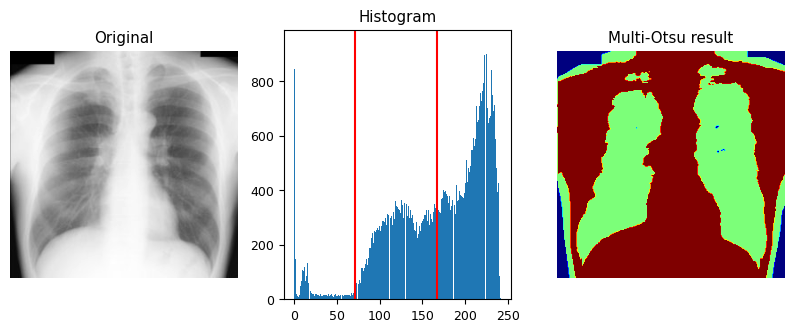

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Import OpenCV
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

image = cv2.imread('/content/JPCLN146.png', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
assert image is not None, "Image not found or unable to load."

# Applying multi-Otsu threshold for the default value, generating three classes.
thresholds = threshold_multiotsu(image)
print(thresholds
      )
# Using the threshold values, generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()


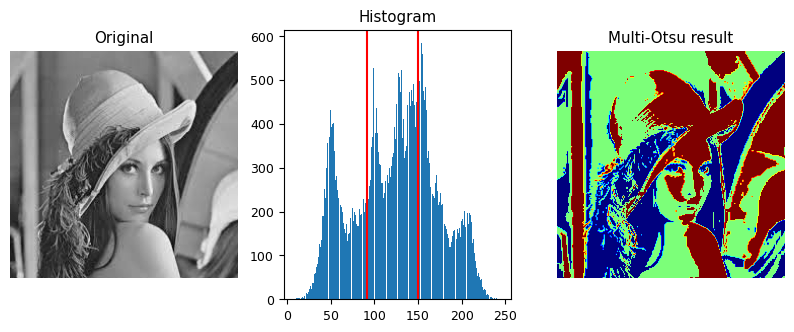

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Import OpenCV
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

image = cv2.imread('/content/download.jpg', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
assert image is not None, "Image not found or unable to load."

# Applying multi-Otsu threshold for the default value, generating three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('/content/DSC_0411.JPG', cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image could not be read, check the file path."

# Apply GaussianBlur to reduce noise
blur = cv2.GaussianBlur(img, (5, 5), 0)

# Calculate the histogram and normalized histogram
hist = cv2.calcHist([blur], [0], None, [256], [0, 256])
hist_norm = hist.ravel() / hist.sum()

# Calculate cumulative sum (Q) and bins
Q = hist_norm.cumsum()
bins = np.arange(256)

# Initialize variables for finding optimal threshold
fn_min = np.inf
optimal_thresh = -1
sigma_b_squared_values = []
valid_thresholds = []  # To store valid thresholds

# Iterate over all possible thresholds
for i in range(1, 256):
    p1, p2 = np.hsplit(hist_norm, [i])  # Split the hist at the threshold
    q1, q2 = Q[i], Q[255] - Q[i]       # Class probabilities
    if q1 < 1.e-6 or q2 < 1.e-6:       # Avoid divisions by zero
        continue
    b1, b2 = np.hsplit(bins, [i])      # Split bins at the threshold
    m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2  # Class means
    v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2  # Class variances
    sigma_b_squared = q1 * q2 * (m1 - m2) ** 2  # Between-class variance

    sigma_b_squared_values.append(sigma_b_squared)  # Store the variance
    valid_thresholds.append(i)  # Store the corresponding threshold

    # Find the threshold that minimizes within-class variance
    fn = v1 * q1 + v2 * q2
    if fn < fn_min:
        fn_min = fn
        optimal_thresh = i

# Find Otsu's threshold using OpenCV for verification
ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Calculated Threshold: {}, OpenCV Threshold: {ret}")

# Plotting
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Original Image
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

# Blurred Image
ax[0, 1].imshow(blur, cmap='gray')
ax[0, 1].set_title('Blurred Image')
ax[0, 1].axis('off')

# Histogram and Threshold
ax[0, 2].hist(blur.ravel(), bins=256)
ax[0, 2].axvline(optimal_thresh, color='r', linestyle='--')
ax[0, 2].set_title('Histogram with Threshold')

# Between-class variance plot
ax[1, 0].plot(valid_thresholds, sigma_b_squared_values)
ax[1, 0].set_title('Between-Class Variance (σ²B)')
ax[1, 0].set_xlabel('Threshold')
ax[1, 0].set_ylabel('σ²B')

# Binary Image using calculated threshold
_, binary_img = cv2.threshold(blur, optimal_thresh, 255, cv2.THRESH_BINARY)
ax[1, 1].imshow(binary_img, cmap='gray')
ax[1, 1].set_title(f'Binary Image (Calculated Threshold: {optimal_thresh})')
ax[1, 1].axis('off')

# Binary Image using OpenCV threshold
ax[1, 2].imshow(otsu, cmap='gray')
ax[1, 2].set_title(f'Binary Image (OpenCV Threshold: {int(ret)})')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Printing the values
print(f"Total Mean (μT): {np.sum(bins * hist_norm)}")
print(f"Class Weights (ω0, ω1) at threshold {optimal_thresh}: ({Q[optimal_thresh]:.4f}, {Q[255] - Q[optimal_thresh]:.4f})")
print(f"Class Means (μ0, μ1) at threshold {optimal_thresh}: ({np.sum(hist_norm[:optimal_thresh+1] * bins[:optimal_thresh+1]) / Q[optimal_thresh]:.4f}, {np.sum(hist_norm[optimal_thresh+1:] * bins[optimal_thresh+1:]) / (Q[255] - Q[optimal_thresh]):.4f})")


In [ ]:
from google.colab.patches import cv2_imshow

Calculated Threshold: 158, OpenCV Threshold: 156.0


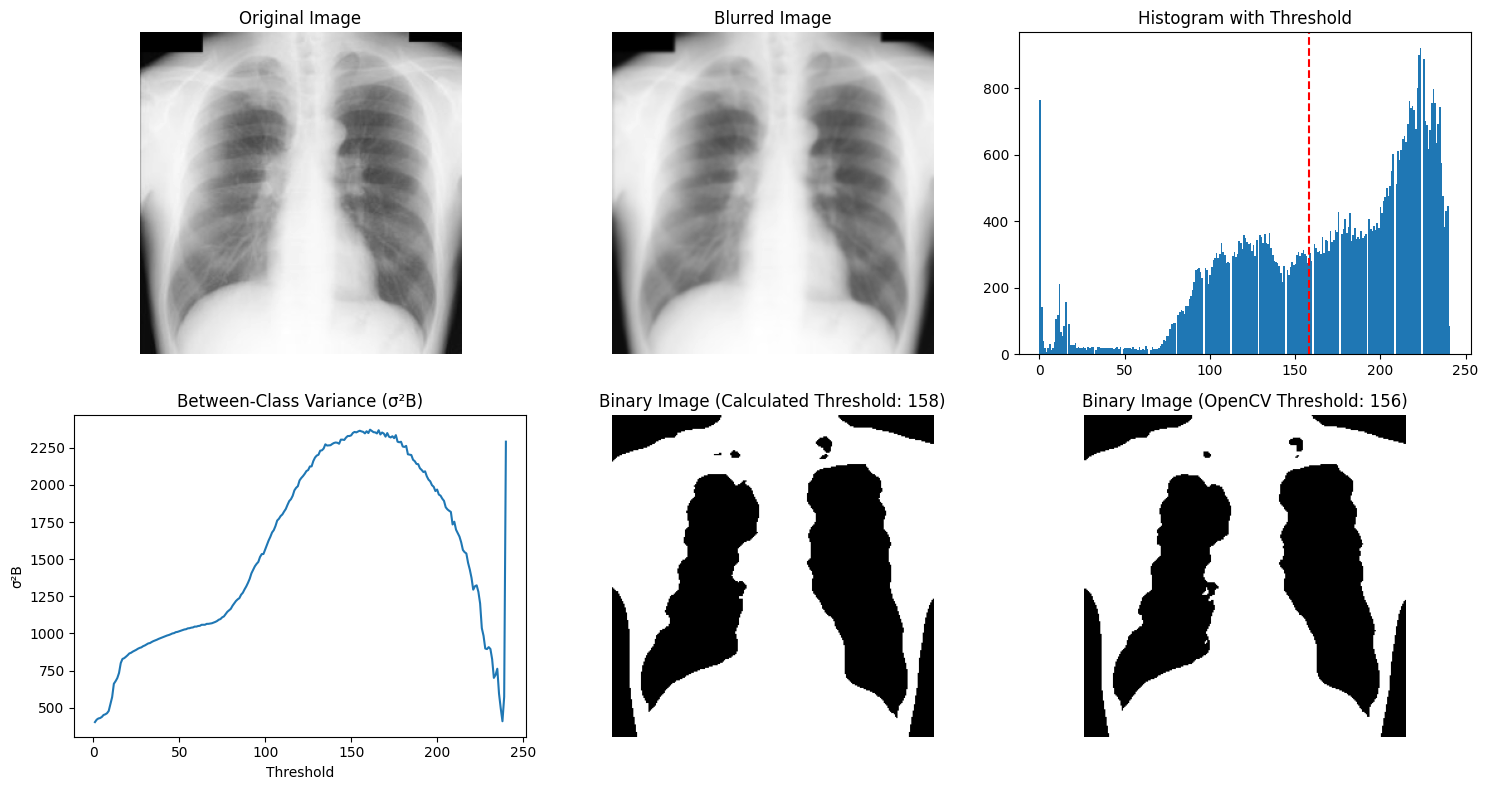

Total Mean (μT): 169.14820861816406
Class Weights (ω0, ω1) at threshold 158: (0.3801, 0.6199)
Class Means (μ0, μ1) at threshold 158: (109.0129, 206.0276)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('/content/JPCLN146.png', cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image could not be read, check the file path."

# Apply GaussianBlur to reduce noise
blur = cv2.GaussianBlur(img, (5, 5), 0)

# Calculate the histogram and normalized histogram
hist = cv2.calcHist([blur], [0], None, [256], [0, 256])
hist_norm = hist.ravel() / hist.sum()

# Calculate cumulative sum (Q) and bins
Q = hist_norm.cumsum()
bins = np.arange(256)

# Initialize variables for finding optimal threshold
fn_min = np.inf
optimal_thresh = -1
sigma_b_squared_values = []
valid_thresholds = []  # To store valid thresholds

# Iterate over all possible thresholds
for i in range(1, 256):
    p1, p2 = np.hsplit(hist_norm, [i])  # Split the hist at the threshold
    q1, q2 = Q[i], Q[255] - Q[i]       # Class probabilities
    if q1 < 1.e-6 or q2 < 1.e-6:       # Avoid divisions by zero
        continue
    b1, b2 = np.hsplit(bins, [i])      # Split bins at the threshold
    m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2  # Class means
    v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2  # Class variances
    sigma_b_squared = q1 * q2 * (m1 - m2) ** 2  # Between-class variance

    sigma_b_squared_values.append(sigma_b_squared)  # Store the variance
    valid_thresholds.append(i)  # Store the corresponding threshold

    # Find the threshold that minimizes within-class variance
    fn = v1 * q1 + v2 * q2
    if fn < fn_min:
        fn_min = fn
        optimal_thresh = i

# Find Otsu's threshold using OpenCV for verification

ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Calculated Threshold: {optimal_thresh}, OpenCV Threshold: {ret}")

# Plotting
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Original Image
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

# Blurred Image
ax[0, 1].imshow(blur, cmap='gray')
ax[0, 1].set_title('Blurred Image')
ax[0, 1].axis('off')

# Histogram and Threshold
ax[0, 2].hist(blur.ravel(), bins=256)
ax[0, 2].axvline(optimal_thresh, color='r', linestyle='--')
ax[0, 2].set_title('Histogram with Threshold')

# Between-class variance plot
ax[1, 0].plot(valid_thresholds, sigma_b_squared_values)
ax[1, 0].set_title('Between-Class Variance (σ²B)')
ax[1, 0].set_xlabel('Threshold')
ax[1, 0].set_ylabel('σ²B')

# Binary Image using calculated threshold
_, binary_img = cv2.threshold(blur, optimal_thresh, 255, cv2.THRESH_BINARY)
ax[1, 1].imshow(binary_img, cmap='gray')
ax[1, 1].set_title(f'Binary Image (Calculated Threshold: {optimal_thresh})')
ax[1, 1].axis('off')

# Binary Image using OpenCV threshold
ax[1, 2].imshow(otsu, cmap='gray')
ax[1, 2].set_title(f'Binary Image (OpenCV Threshold: {int(ret)})')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Printing the values
print(f"Total Mean (μT): {np.sum(bins * hist_norm)}")
print(f"Class Weights (ω0, ω1) at threshold {optimal_thresh}: ({Q[optimal_thresh]:.4f}, {Q[255] - Q[optimal_thresh]:.4f})")
print(f"Class Means (μ0, μ1) at threshold {optimal_thresh}: ({np.sum(hist_norm[:optimal_thresh+1] * bins[:optimal_thresh+1]) / Q[optimal_thresh]:.4f}, {np.sum(hist_norm[optimal_thresh+1:] * bins[optimal_thresh+1:]) / (Q[255] - Q[optimal_thresh]):.4f})")


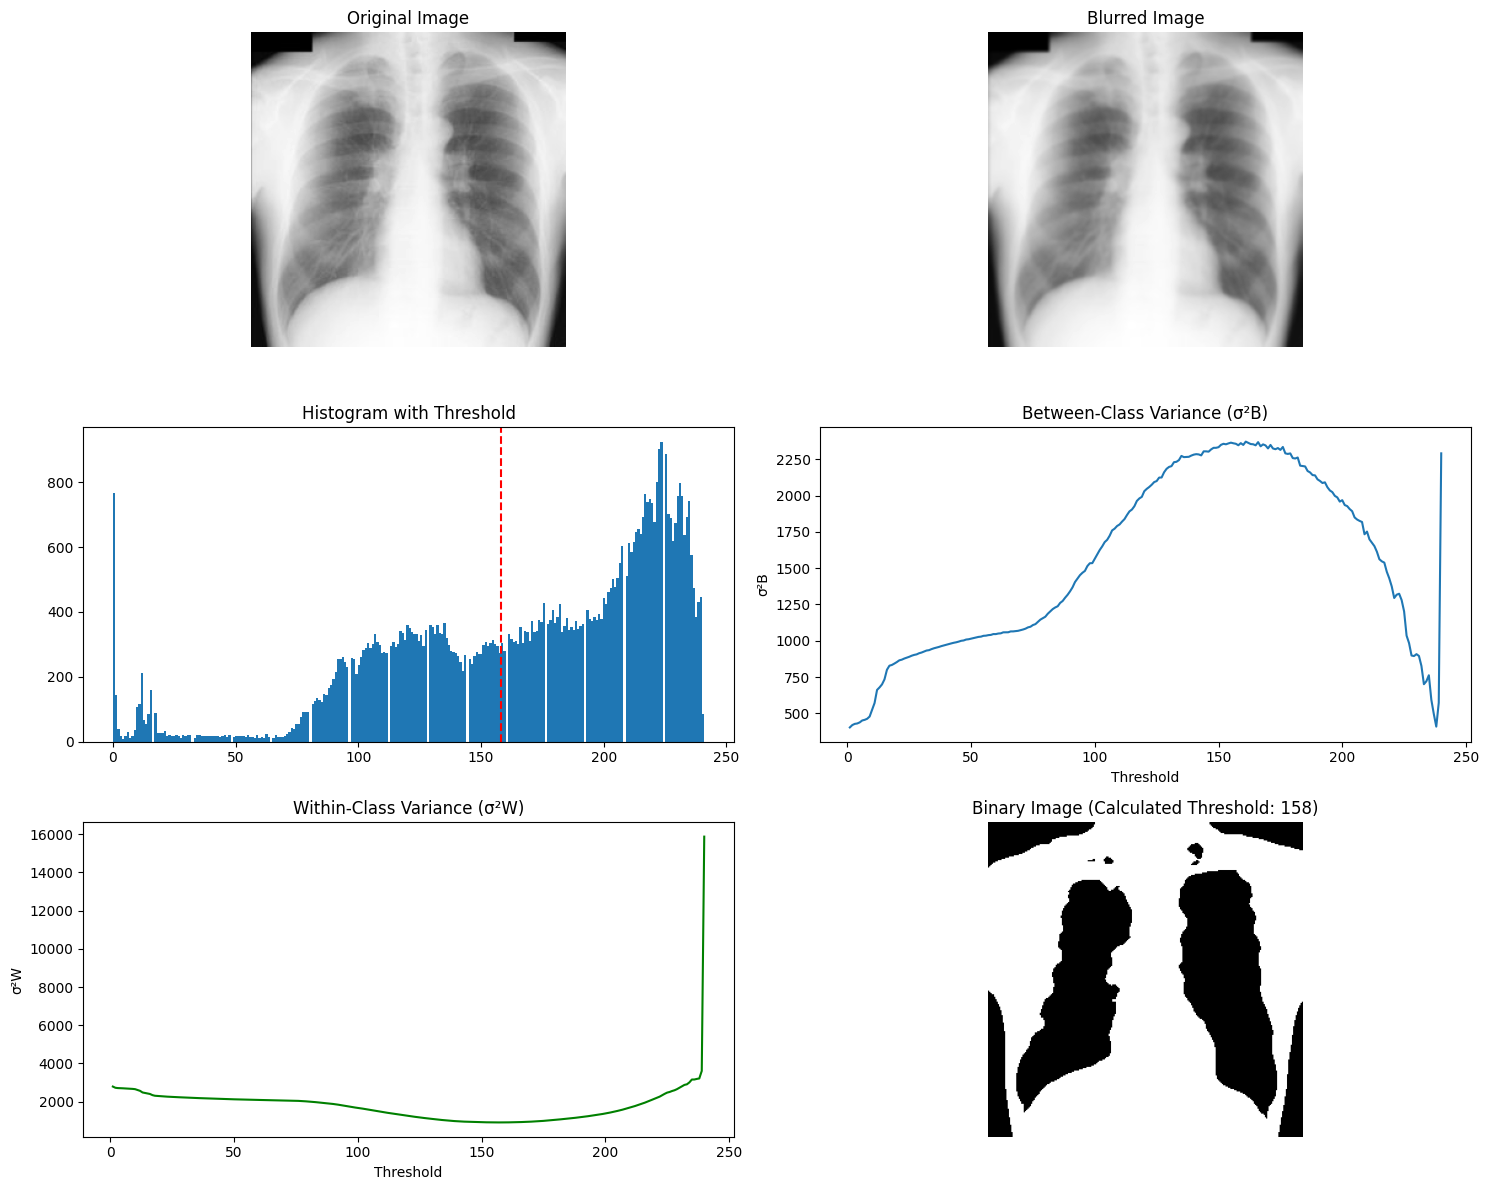

Calculated Threshold: 158, OpenCV Threshold: 156.0
Total Mean (μT): 169.14820861816406
Class Weights (ω0, ω1) at threshold 158: (0.3801, 0.6199)
Class Means (μ0, μ1) at threshold 158: (109.0129, 206.0276)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('/content/JPCLN146.png', cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image could not be read, check the file path."

# Apply GaussianBlur to reduce noise
blur = cv2.GaussianBlur(img, (5, 5), 0)

# Calculate the histogram and normalized histogram
hist = cv2.calcHist([blur], [0], None, [256], [0, 256])
hist_norm = hist.ravel() / hist.sum()

# Calculate cumulative sum (Q) and bins
Q = hist_norm.cumsum()
bins = np.arange(256)

# Initialize variables for finding optimal threshold
fn_min = np.inf
optimal_thresh = -1
sigma_b_squared_values = []
sigma_w_squared_values = []  # To store within-class variance values
valid_thresholds = []  # To store valid thresholds

# Iterate over all possible thresholds
for i in range(1, 256):
    p1, p2 = np.hsplit(hist_norm, [i])  # Split the histogram at the threshold
    q1, q2 = Q[i], Q[255] - Q[i]       # Class probabilities
    if q1 < 1.e-6 or q2 < 1.e-6:       # Avoid divisions by zero
        continue
    b1, b2 = np.hsplit(bins, [i])      # Split bins at the threshold
    m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2  # Class means
    v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2  # Class variances
    sigma_b_squared = q1 * q2 * (m1 - m2) ** 2  # Between-class variance
    sigma_w_squared = v1 * q1 + v2 * q2  # Within-class variance

    sigma_b_squared_values.append(sigma_b_squared)  # Store between-class variance
    sigma_w_squared_values.append(sigma_w_squared)  # Store within-class variance
    valid_thresholds.append(i)  # Store the corresponding threshold

    # Update the optimal threshold based on minimal within-class variance
    if sigma_w_squared < fn_min:
        fn_min = sigma_w_squared
        optimal_thresh = i

# Find Otsu's threshold using OpenCV for verification
ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Plotting
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))  # Adjust subplot layout

# Original Image
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

# Blurred Image
ax[0, 1].imshow(blur, cmap='gray')
ax[0, 1].set_title('Blurred Image')
ax[0, 1].axis('off')

# Histogram and Threshold
ax[1, 0].hist(blur.ravel(), bins=256)
ax[1, 0].axvline(optimal_thresh, color='r', linestyle='--')
ax[1, 0].set_title('Histogram with Threshold')

# Between-class variance plot
ax[1, 1].plot(valid_thresholds, sigma_b_squared_values)
ax[1, 1].set_title('Between-Class Variance (σ²B)')
ax[1, 1].set_xlabel('Threshold')
ax[1, 1].set_ylabel('σ²B')

# Within-class variance plot
ax[2, 0].plot(valid_thresholds, sigma_w_squared_values, color='green')
ax[2, 0].set_title('Within-Class Variance (σ²W)')
ax[2, 0].set_xlabel('Threshold')
ax[2, 0].set_ylabel('σ²W')

# Binary Image using calculated threshold
_, binary_img = cv2.threshold(blur, optimal_thresh, 255, cv2.THRESH_BINARY)
ax[2, 1].imshow(binary_img, cmap='gray')
ax[2, 1].set_title(f'Binary Image (Calculated Threshold: {optimal_thresh})')
ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print the calculated values
print(f"Calculated Threshold: {optimal_thresh}, OpenCV Threshold: {ret}")
print(f"Total Mean (μT): {np.sum(bins * hist_norm)}")
print(f"Class Weights (ω0, ω1) at threshold {optimal_thresh}: ({Q[optimal_thresh]:.4f}, {Q[255] - Q[optimal_thresh]:.4f})")
print(f"Class Means (μ0, μ1) at threshold {optimal_thresh}: ({np.sum(hist_norm[:optimal_thresh+1] * bins[:optimal_thresh+1]) / Q[optimal_thresh]:.4f}, {np.sum(hist_norm[optimal_thresh+1:] * bins[optimal_thresh+1:]) / (Q[255] - Q[optimal_thresh]):.4f})")


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('/content/JPCLN146.png', cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image could not be read, check the file path."

# Apply GaussianBlur to reduce noise
blur = cv2.GaussianBlur(img, (5, 5), 0)

# Calculate the histogram and normalized histogram
hist = cv2.calcHist([blur], [0], None, [256], [0, 256])
hist_norm = hist.ravel() / hist.sum()

# Calculate cumulative sum (Q) and bins
Q = hist_norm.cumsum()
bins = np.arange(256)

# Calculate total mean (mewT) and total variance (sigmaT square)
mewT = np.sum(bins * hist_norm)
sigmaT_squared = np.sum(((bins - mewT) ** 2) * hist_norm)

# Initialize variables for finding optimal threshold
fn_min = np.inf
optimal_thresh = -1
sigma_b_squared_values = []
criterion_values = []
valid_thresholds = []  # To store valid thresholds

# Iterate over all possible thresholds
for i in range(1, 256):
    p1, p2 = np.hsplit(hist_norm, [i])  # Split the hist at the threshold
    q1, q2 = Q[i], Q[255] - Q[i]       # Class probabilities
    if q1 < 1.e-6 or q2 < 1.e-6:       # Avoid divisions by zero
        continue
    b1, b2 = np.hsplit(bins, [i])      # Split bins at the threshold
    m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2  # Class means
    v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2  # Class variances
    sigma_b_squared = q1 * q2 * (m1 - m2) ** 2  # Between-class variance

    sigma_b_squared_values.append(sigma_b_squared)  # Store the variance
    valid_thresholds.append(i)  # Store the corresponding threshold

    # Calculate criterion measure J(threshold) and store it
    criterion_value = sigma_b_squared / sigmaT_squared
    criterion_values.append(criterion_value)

    # Find the threshold that minimizes within-class variance
    fn = v1 * q1 + v2 * q2
    if fn < fn_min:
        fn_min = fn
        optimal_thresh = i

# Find the maximum between-class variance and calculate eta*
max_sigma_b_squared = max(sigma_b_squared_values)
eta_star = max_sigma_b_squared / sigmaT_squared

# Find Otsu's threshold using OpenCV for verification
ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Calculated Threshold: {optimal_thresh}, OpenCV Threshold: {ret}")
print(f"Maximum Between-Class Variance (σB² at k*): {max_sigma_b_squared:.4f}")
print(f"Total Variance (σT²): {sigmaT_squared:.4f}")
print(f"Separability Measure (η*): {eta_star:.4f}")

# Plotting and saving each plot as a separate image

# Original Image
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.savefig('original_image.png', dpi=300)
plt.close()

# Blurred Image
plt.figure(figsize=(6, 6))
plt.imshow(blur, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.savefig('blurred_image.png', dpi=300)
plt.close()

# Histogram and Threshold
plt.figure(figsize=(6, 6))
plt.hist(blur.ravel(), bins=256)
plt.axvline(optimal_thresh, color='r', linestyle='--')
plt.title('Histogram with Threshold')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.savefig('histogram_with_threshold.png', dpi=300)
plt.close()

# Between-class variance plot
plt.figure(figsize=(6, 6))
plt.plot(valid_thresholds, sigma_b_squared_values)
plt.title('Between-Class Variance (σ²B)')
plt.xlabel('Threshold')
plt.ylabel('σ²B')
plt.savefig('between_class_variance.png', dpi=300)
plt.close()

# Criterion Measure Plot
plt.figure(figsize=(6, 6))
plt.plot(valid_thresholds, criterion_values)
plt.title('Otsu Criterion Measure J(threshold)')
plt.xlabel('Threshold')
plt.ylabel('J(threshold)')
plt.savefig('criterion_measure.png', dpi=300)
plt.close()

# Binary Image using calculated threshold
plt.figure(figsize=(6, 6))
plt.imshow(binary_img, cmap='gray')
plt.title(f'Binary Image (Calculated Threshold: {optimal_thresh})')
plt.axis('off')
plt.savefig('binary_image_calculated_threshold.png', dpi=300)
plt.close()

# Binary Image using OpenCV threshold
plt.figure(figsize=(6, 6))
plt.imshow(otsu, cmap='gray')
plt.title(f'Binary Image (OpenCV Threshold: {int(ret)})')
plt.axis('off')
plt.savefig('binary_image_opencv_threshold.png', dpi=300)
plt.close()

# Printing the values
print(f"Total Mean (μT): {mewT:.4f}")
print(f"Total Variance (σT²): {sigmaT_squared:.4f}")
print(f"Class Weights (ω0, ω1) at threshold {optimal_thresh}: ({Q[optimal_thresh]:.4f}, {Q[255] - Q[optimal_thresh]:.4f})")
print(f"Class Means (μ0, μ1) at threshold {optimal_thresh}: ({np.sum(hist_norm[:optimal_thresh+1] * bins[:optimal_thresh+1]) / Q[optimal_thresh]:.4f}, {np.sum(hist_norm[optimal_thresh+1:] * bins[optimal_thresh+1:]) / (Q[255] - Q[optimal_thresh]):.4f})")


Calculated Threshold: 158, OpenCV Threshold: 156.0
Maximum Between-Class Variance (σB² at k*): 2372.2499
Total Variance (σT²): 3129.8335
Separability Measure (η*): 0.7579
Total Mean (μT): 169.1482
Total Variance (σT²): 3129.8335
Class Weights (ω0, ω1) at threshold 158: (0.3801, 0.6199)
Class Means (μ0, μ1) at threshold 158: (109.0129, 206.0276)


In [ ]:
import numpy as np

def generate_values(mean, std_dev, num_values=5, decimals=3):
    # Generate the values using normal distribution with the specified mean and standard deviation
    values = np.random.normal(loc=mean, scale=std_dev, size=num_values)

    # Round values to the specified number of decimals
    rounded_values = [round(val, decimals) for val in values]

    return rounded_values

# Example usage:
mean = 54.251
std_dev = 0.00876163964572566
generated_values = generate_values(mean, std_dev)
print("Generated Values:", generated_values)


Generated Values: [72.95, 72.968, 72.946, 72.952, 72.946]


In [ ]:
def calculate_standard_deviation(values):
    mean = sum(values) / len(values)

    # Calculate the variance
    variance = sum((x - mean) ** 2 for x in values) / len(values)

    # Calculate the standard deviation
    std_dev = variance ** 0.5

    return std_dev

# Example usage#93.357
values = [76.711, 76.702, 76.722, 76.698, 76.732]
std_dev = calculate_standard_deviation(values)
print("Standard Deviation (Manual Calculation):", std_dev)


Standard Deviation (Manual Calculation): 0.012585706178042748


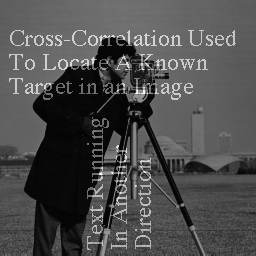

False

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the images
img1 = cv2.imread('/content/cameraman.tif', cv2.IMREAD_GRAYSCALE)  # Ensure this path is correct
img2 = cv2.imread('/content/text.tif', cv2.IMREAD_GRAYSCALE)  # Ensure this path is correct

# Check if images are loaded
if img1 is None or img2 is None:
    raise Exception("Could not load one or both images. Check the file paths.")

# Resize img2 to match img1's dimensions if necessary
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_AREA)

# Blend the images
# Adjust alpha (img1 weight) and beta (img2 weight) to change visibility preference
alpha = 0.6
beta = 0.4
blended_image = cv2.addWeighted(img1, alpha, img2, beta, 0)

# Display the result
cv2_imshow( blended_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally, save the result to a file
cv2.imwrite('content/blended_image.tif', blended_image)


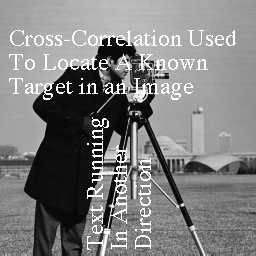

False

In [ ]:
import cv2
import numpy as np

# Load the images
img1 = cv2.imread('/content/cameraman.tif', cv2.IMREAD_GRAYSCALE)  # Ensure the path is correct
img2 = cv2.imread('/content/text.tif', cv2.IMREAD_GRAYSCALE)       # Ensure the path is correct

# Check if images are loaded
if img1 is None or img2 is None:
    raise Exception("Could not load one or both images. Check the file paths.")

# Resize img2 to match img1's dimensions if necessary
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_AREA)

# Convert images to double (float64 in numpy)
img1_double = img1.astype(np.float64)
img2_double = img2.astype(np.float64)

# Scale img2 by 255 and add to img1
result = img1_double + 255 * img2_double

# Convert the result back to uint8
result_uint8 = np.clip(result, 0, 255).astype(np.uint8)

# Display the result
cv2_imshow( result_uint8)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally, save the result to a file
cv2.imwrite('content/superimposed_image.tif', result_uint8)


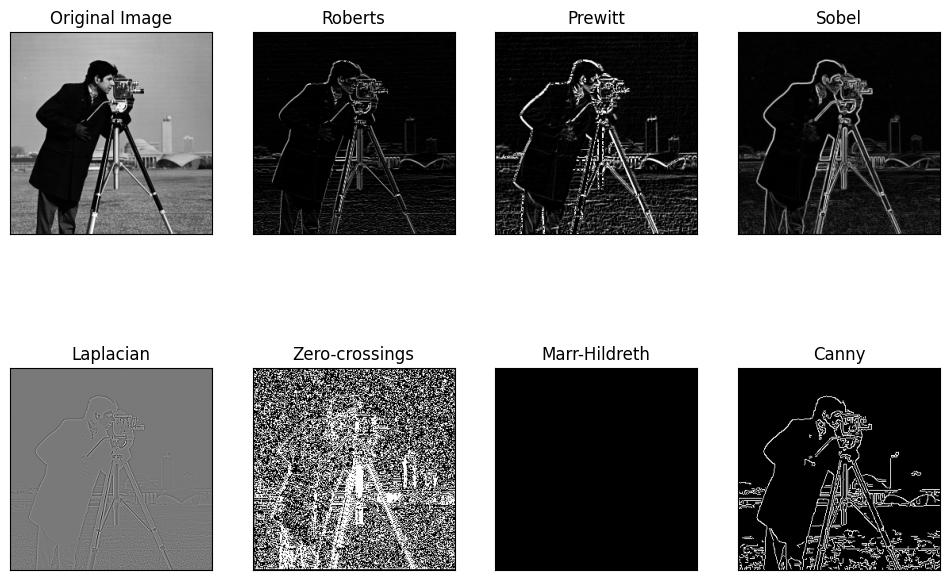

In [ ]:
import cv2
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

# Load the image
img = cv2.imread('/content/cameraman.tif', cv2.IMREAD_GRAYSCALE)

# a. Roberts
kernel_roberts_x = np.array([[1, 0], [0, -1]])
kernel_roberts_y = np.array([[0, 1], [-1, 0]])
roberts_x = cv2.filter2D(img, -1, kernel_roberts_x)
roberts_y = cv2.filter2D(img, -1, kernel_roberts_y)
roberts = roberts_x + roberts_y

# b. Prewitt
kernel_prewitt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernel_prewitt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
prewitt_x = cv2.filter2D(img, -1, kernel_prewitt_x)
prewitt_y = cv2.filter2D(img, -1, kernel_prewitt_y)
prewitt = prewitt_x + prewitt_y

# c. Sobel
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)

# d. Laplacian
laplacian = cv2.Laplacian(img, cv2.CV_64F)

# e. Zero-crossings of a Laplacian
laplacian = cv2.Laplacian(img, cv2.CV_64F)
sign_changes = np.logical_xor(laplacian[:-1] < 0, laplacian[1:] > 0)
zero_crossings = np.zeros_like(laplacian)
zero_crossings[:-1][sign_changes] = 255  # Mark zero crossings with white

# f. Marr-Hildreth using Gaussian Laplacian
sigma = 2
gaussian_laplace = ndimage.gaussian_laplace(img, sigma=sigma)
marr_hildreth = np.zeros_like(gaussian_laplace)
marr_hildreth[gaussian_laplace < 0] = 255

# g. Canny
canny = cv2.Canny(img, 100, 200)

# Plot all the results
titles = ['Original Image', 'Roberts', 'Prewitt', 'Sobel', 'Laplacian', 'Zero-crossings', 'Marr-Hildreth', 'Canny']
images = [img, roberts, prewitt, sobel, laplacian, zero_crossings, marr_hildreth, canny]

plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()
